In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
# from tensorflow import set_random_seed
from tensorflow.keras import optimizers
from keras import Sequential
from keras.models import Model
# from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [2]:
# first = 'data/1st_test'
# second = 'data/2nd_test'
# third = 'data/4th_test/txt'

# SET HYPERPARAMETERS AND EXTERNAL VALUES

In [3]:
DATASET_PATH = 'data/2nd_test'
MODEL_PATH = 'bearing/experiment-2/bearing-1'
DATASET_COLUMN = 0
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001


In [4]:
def readData(dataDir, setName,set1=False):
    files = os.listdir(dataDir)
    print("Number of files:",len(files))
    
    bearing1= list()
    bearing2= list()
    bearing3= list()
    bearing4= list()

    bearing_list = {setName+"_bearing-1" : bearing1,setName+"_bearing-2" : bearing2,setName+"_bearing-3" : bearing3,setName+"_bearing-4" : bearing4}
    
    cols=['bearing-1','bearing-2','bearing-3','bearing-4']
    
    for filename in files:

        dataset=pd.read_csv(os.path.join(dataDir, filename), sep='\t', header=None, names=cols)

        avg_df = dataset.groupby(dataset.index // 5).mean()
        
        for bearing in cols:
            dict_key = setName+"_"+bearing
            if dict_key in bearing_list:
                b = pd.DataFrame(avg_df[bearing]).T
                bearing_list[setName+"_"+bearing].append(b)
    
    return bearing_list

In [5]:
data = readData(DATASET_PATH, "S2")
for bearing in data:  # edited error
    print(bearing,len(data[bearing]))

Number of files: 984
S2_bearing-1 984
S2_bearing-2 984
S2_bearing-3 984
S2_bearing-4 984


# split data into training and test

In [6]:
bearing1 = pd.concat(data[f"S2_bearing-{DATASET_COLUMN + 1}"])
split_len = int(len(bearing1) * TRAIN_SPLIT)
print(split_len)
train = bearing1.iloc[0:split_len]
test = bearing1.iloc[split_len:]
train.reset_index(drop= True, inplace=True)
test.reset_index(drop= True, inplace=True)
print(train.shape, test.shape)

787
(787, 4096) (197, 4096)


In [7]:
# Standardarize train and test set
scaler = preprocessing.StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train))
test_scaled = pd.DataFrame(scaler.transform(test))
print(train_scaled.shape, test_scaled.shape)

(787, 4096) (197, 4096)


# prepare data for LSTM

In [8]:
def temporalize(X, lookback):
    output_X = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
    return output_X


def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [9]:
n_features = train_scaled.shape[1] 
lookback = 20  

# Temporalize the data
X = temporalize(X = train_scaled.values, lookback = lookback)
X_t = temporalize(X = test_scaled.values, lookback = lookback)

In [10]:
X_train_lstm = np.array(X)
X_test_lstm = np.array(X_t)
X_train = X_train_lstm.reshape(X_train_lstm.shape[0], lookback, n_features)
X_test = X_test_lstm.reshape(X_test_lstm.shape[0], lookback, n_features)
print(X_train.shape, X_test.shape)

(766, 20, 4096) (176, 20, 4096)


# LSTM AE Anomaly Detector

In [11]:
timesteps =  X_train.shape[1] # equal to the lookback=20
n_features =  X_train.shape[2] # 4096

In [12]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(600, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(250, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(250, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(600, activation='tanh', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 600)           11272800  
                                                                 
 lstm_1 (LSTM)               (None, 250)               851000    
                                                                 
 repeat_vector (RepeatVector  (None, 20, 250)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 20, 250)           501000    
                                                                 
 lstm_3 (LSTM)               (None, 20, 600)           2042400   
                                                                 
 time_distributed (TimeDistr  (None, 20, 4096)         2461696   
 ibuted)                                                

In [13]:
adam = optimizers.Adam(LEARNING_RATE)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=EPOCHS,
                                                batch_size=BATCH_SIZE,
                                                validation_split=VAL_SPLIT,
                                                verbose=2).history

Epoch 1/100
11/11 - 5s - loss: 0.9529 - val_loss: 1.3647 - 5s/epoch - 478ms/step
Epoch 2/100
11/11 - 1s - loss: 0.9432 - val_loss: 1.3626 - 1s/epoch - 122ms/step
Epoch 3/100
11/11 - 1s - loss: 0.9390 - val_loss: 1.3542 - 1s/epoch - 115ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9349 - val_loss: 1.3537 - 1s/epoch - 120ms/step
Epoch 5/100
11/11 - 1s - loss: 0.9290 - val_loss: 1.3545 - 1s/epoch - 120ms/step
Epoch 6/100
11/11 - 1s - loss: 0.9225 - val_loss: 1.3544 - 1s/epoch - 117ms/step
Epoch 7/100
11/11 - 1s - loss: 0.9177 - val_loss: 1.3601 - 1s/epoch - 123ms/step
Epoch 8/100
11/11 - 1s - loss: 0.9108 - val_loss: 1.3611 - 1s/epoch - 130ms/step
Epoch 9/100
11/11 - 1s - loss: 0.9070 - val_loss: 1.3597 - 1s/epoch - 113ms/step
Epoch 10/100
11/11 - 1s - loss: 0.9040 - val_loss: 1.3591 - 1s/epoch - 115ms/step
Epoch 11/100
11/11 - 1s - loss: 0.9001 - val_loss: 1.3679 - 1s/epoch - 121ms/step
Epoch 12/100
11/11 - 1s - loss: 0.8995 - val_loss: 1.3595 - 1s/epoch - 116ms/step
Epoch 13/100
11/11 - 1s -

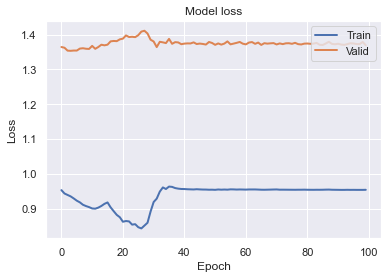

In [14]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [15]:
X_pred_train = lstm_autoencoder.predict(np.array(X_train))
X_pred_train = pd.DataFrame(flatten(X_pred_train))

24/24 [==============================] - 1s 17ms/step


C:\DRIVE\SOFTWARE\_Archiv\_global-venv-pc1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Training Reconstruction Error')

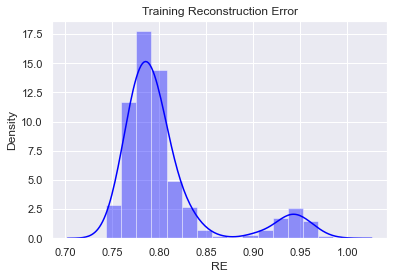

In [16]:
scored = pd.DataFrame(index=X_pred_train.index)
scored['RE'] = np.mean(np.abs(X_pred_train - flatten(X_train)), axis = 1)
plt.figure()
sns.distplot(scored['RE'],
             bins = 15, 
             kde= True,
            color = 'blue')
plt.title("Training Reconstruction Error")
# plt.savefig("plots/RE_medium")

In [17]:
scored.describe()

,RE
count,766.000000
mean,0.806271
std,0.051330
min,0.743552
25%,0.776498
50%,0.790847
75%,0.807810
max,0.985347


In [18]:
X_pred_test = lstm_autoencoder.predict(np.array(X_test))
X_pred_test = pd.DataFrame(flatten(X_pred_test))

6/6 [==============================] - 0s 18ms/step


C:\DRIVE\SOFTWARE\_Archiv\_global-venv-pc1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Reconstruction loss Bearing 1 (Test set)')

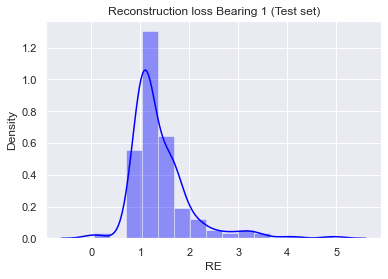

In [19]:
scored_test = pd.DataFrame(index=X_pred_test.index)
scored_test['RE'] = np.mean(np.abs(X_pred_test - flatten(X_test)), axis = 1)  # corrected error
plt.figure()
sns.distplot(scored_test['RE'],bins = 15, kde= True,color = 'blue')
plt.title("Reconstruction loss Bearing 1 (Test set)")
# plt.savefig("plots/RE_test")

In [20]:
scored_test['Threshold'] = 1.0
scored_test['Anomaly'] = scored_test['RE'] > scored_test['Threshold']  # corrected error

<AxesSubplot:title={'center':'Failure of Bearing 1 (Set-2)'}>

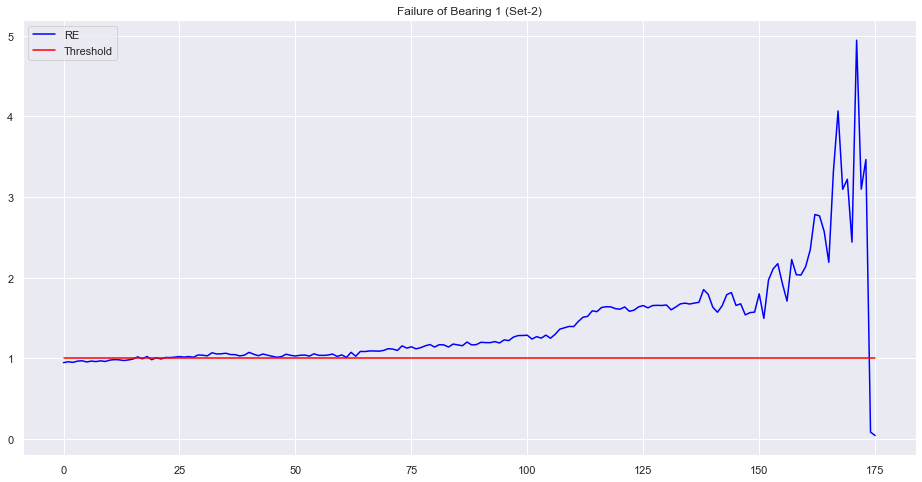

In [21]:
scored_test.plot(figsize = (16,8), color = ['blue','red'],title="Failure of Bearing 1 (Set-2)")

# MY EVALUATION

In [22]:


lstm_autoencoder.save(f'../model/baseline/{MODEL_PATH}.h5')
scored_test['RE'].to_csv('baseline_anomaly_scores.csv', index=False)